In [109]:
import numpy as np
import hoomd
import itertools
import gsd.hoomd
import math

def lj_system(n, spacing, box_factor=3):
    """
    Initating a system with one type of particle (A)
    """
    N_particles = n
    spacing = spacing
    K = math.ceil(N_particles**(1 / 3))
    L = K * spacing
    x = np.linspace(-L / 2, L / 2, K, endpoint=False)
    position = list(itertools.product(x, repeat=3))

    snapshot = gsd.hoomd.Frame()
    snapshot.particles.N = N_particles
    snapshot.particles.position = position[0:N_particles]
    snapshot.particles.typeid = [0] * N_particles
    snapshot.configuration.box = [L*box_factor, L*box_factor, L*box_factor, 0, 0, 0]
    snapshot.particles.types = ['A']
    return snapshot


def pair_force(sigma=1, epsilon=1):
    """
    Creates non-bonded forces between A particles.
    """
    cell = hoomd.md.nlist.Cell(buffer=0.4)
    lj = hoomd.md.pair.LJ(nlist=cell)
    lj.params[('A', 'A')] = dict(epsilon=epsilon, sigma=sigma)
    lj.r_cut[('A', 'A')] = 2.5 * sigma
    return lj

In [110]:
init_snap = lj_system(n=100, spacing=1.5, box_factor=2)
with gsd.hoomd.open(name='logs/N_100/init.gsd', mode='w') as f:
    f.append(init_snap)

In [111]:
init_snap.configuration.box

array([15., 15., 15.,  0.,  0.,  0.], dtype=float32)

In [112]:
from flowermd.base import Simulation
forces = [pair_force(sigma=1, epsilon=1)]
sim = Simulation(initial_state=init_snap, 
                 forcefield=forces, 
                 dt=0.0001,
                 gsd_write_freq=1000,
                 gsd_file_name='logs/N_100/trajectory_shrink.gsd',
                 log_write_freq=1000,
                 log_file_name='logs/N_100/log_shrink.txt')

Initializing simulation state from a gsd.hoomd.Frame.


In [113]:
gsd_logger = hoomd.logging.Logger(
    categories=["scalar", "string", "sequence", "particle"]
)
gsd_logger.add(sim, quantities=["timestep", "tps"])


gsd_logger.add(sim.operations.computes[0], quantities=sim.log_quantities)

for f in sim._forcefield:
    gsd_logger.add(f, quantities=["energy", "forces", "energies"])

gsd_writer = hoomd.write.GSD(
    filename=sim.gsd_file_name,
    trigger=hoomd.trigger.Periodic(int(sim.gsd_write_freq)),
    mode="wb",
    dynamic=["momentum", "property"],
    filter=hoomd.filter.All(),
    logger=gsd_logger,
)
gsd_writer.maximum_write_buffer_size = sim.maximum_write_buffer_size
sim.operations.writers[0] = gsd_writer


In [114]:
sim.run_update_volume(final_box_lengths=[6, 6, 6], n_steps=1e3, period=10, kT=1.5, tau_kt=0.1)

Step 1000 of 1000; TPS: 4976.68; ETA: 0.0 minutes


In [115]:
sim.flush_writers()

In [116]:
sim.save_restart_gsd("logs/N_100/restart.gsd")

In [78]:
sim.run_NVT(n_steps=1e6, kT=1.5, tau_kt=0.1, write_at_start=True)
sim.run_NVT(n_steps=1e6, kT=3.0, tau_kt=0.1, write_at_start=True)
sim.run_NVT(n_steps=1e6, kT=5.0, tau_kt=0.1, write_at_start=True)
sim.run_NVT(n_steps=1e6, kT=7.0, tau_kt=0.1, write_at_start=True)

Step 999 of 1000000; TPS: 30359.21; ETA: 0.5 minutes
Step 1999 of 1000000; TPS: 31602.24; ETA: 0.5 minutes
Step 2999 of 1000000; TPS: 32236.22; ETA: 0.5 minutes
Step 3999 of 1000000; TPS: 32667.3; ETA: 0.5 minutes
Step 4999 of 1000000; TPS: 33004.76; ETA: 0.5 minutes
Step 5999 of 1000000; TPS: 33271.4; ETA: 0.5 minutes
Step 6999 of 1000000; TPS: 33480.67; ETA: 0.5 minutes
Step 7999 of 1000000; TPS: 33691.77; ETA: 0.5 minutes
Step 8999 of 1000000; TPS: 33811.0; ETA: 0.5 minutes
Step 9999 of 1000000; TPS: 33946.81; ETA: 0.5 minutes
Step 10999 of 1000000; TPS: 32762.32; ETA: 0.5 minutes
Step 11999 of 1000000; TPS: 32851.38; ETA: 0.5 minutes
Step 12999 of 1000000; TPS: 33095.12; ETA: 0.5 minutes
Step 13999 of 1000000; TPS: 33347.79; ETA: 0.5 minutes
Step 14999 of 1000000; TPS: 33542.35; ETA: 0.5 minutes
Step 15999 of 1000000; TPS: 33724.07; ETA: 0.5 minutes
Step 16999 of 1000000; TPS: 33905.1; ETA: 0.5 minutes
Step 17999 of 1000000; TPS: 34074.17; ETA: 0.5 minutes
Step 18999 of 1000000; TP

In [79]:
sim.flush_writers()

In [80]:
import freud
def find_neighbors(points, L, NN=40):
    box = freud.box.Box.cube(L)
    aq = freud.locality.AABBQuery(box, points)

    query_points = points
    query_result = aq.query(query_points, dict(num_neighbors=NN, exclude_ii=True))
    nlist = query_result.toNeighborList()
    neighbor_list = np.asarray(list(zip(nlist.query_point_indices, nlist.point_indices)))
    return neighbor_list
    

In [81]:
import freud

traj = gsd.hoomd.open("logs/N_100/trajectory.gsd")
positions = []
neighbor_list = []
force = []
energy = []
for frame in traj[3:]:
    L = frame.configuration.box[0]
    neighbor_list.append(find_neighbors(frame.particles.position, L))
    positions.append(frame.particles.position)
    energy.append(frame.log['md/pair/LJ/energy'])
    force.append(frame.log['particles/md/pair/LJ/forces'])


In [86]:
len(force)

3999

In [91]:
import pandas as pd
columns = [
    "position",
    "force",
    "energy",
    "neighbor_list"
]

new_traj_df = pd.DataFrame(columns=columns)
new_traj_df["position"] = positions
new_traj_df["force"] = force
new_traj_df["energy"] = energy
new_traj_df["neighbor_list"] = neighbor_list

In [92]:
new_traj_df = new_traj_df.sample(frac=1).reset_index(drop=True)# shuffle dataset

In [93]:
import os
target_datapath="/home/marjan/Documents/code-base/ml_datasets/iso_N_100"

new_traj_df.to_pickle(os.path.join(target_datapath, "raw.pkl"))
test_frac = 0.1
val_frac = 0.1

dataset_len = new_traj_df.shape[0]
test_len = int(dataset_len * test_frac)
val_len = int(dataset_len * val_frac)

test_df = new_traj_df.iloc[:test_len]

val_df = new_traj_df.iloc[test_len: test_len + val_len]

train_df = new_traj_df.iloc[test_len + val_len:]

In [94]:
train_df.to_pickle(os.path.join(target_datapath, 'train.pkl'))
val_df.to_pickle(os.path.join(target_datapath, 'val.pkl'))
test_df.to_pickle(os.path.join(target_datapath, 'test.pkl'))

In [95]:
train_df.shape

(3201, 4)

In [96]:
test_df.shape

(399, 4)

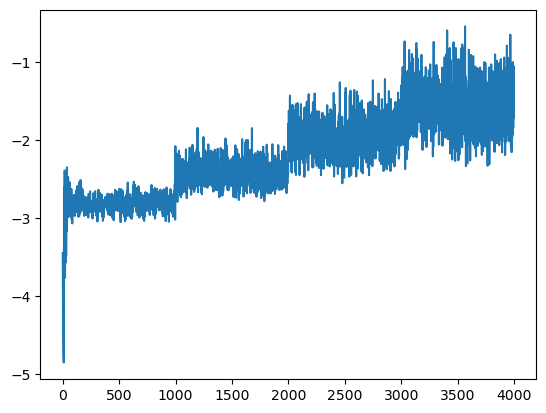

In [101]:
import numpy as np
import matplotlib.pyplot as plt

log = np.genfromtxt("logs/N_100/log.txt", names=True)
potential_energy = log['mdcomputeThermodynamicQuantitiespotential_energy'][4:]/100.
plt.plot(potential_energy)

In [102]:
'neighbor_list' in train_df.columns

True

In [106]:
np.array(list(train_df['neighbor_list'])).shape

(3201, 4000, 2)

In [107]:
np.array(list(train_df['position'])).shape

(3201, 100, 3)

In [108]:
frame.configuration.box

array([6., 6., 6., 0., 0., 0.], dtype=float32)